Histopathologic cancer detection plays an important roll in identifying cancer early in patients. One of the best ways with cancer always evolving is to introduce deep learning into detection with images of possible cancer cells. The work that is being completed in this space is critical for finding cancer earlier in patients which can lead to quicker and better recoveries.

This Kaggle dataset was put together for a competition to use AI/Deep learning to detect malignant cancer cells. The data comes in two forms: tif image files both test and training as well as csv files for the labels of the images. In this project, Keras API will be used to train and predict whether images contain malignant or normal cells.

https://www.kaggle.com/c/histopathologic-cancer-detection/overview

Connecting Kaggle to Colab to have premium TPU to increase speed of modeling. To recreate, create code based on this dataset in Kaggle and copy the first cell in.

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240623%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240623T220355Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D468e14a84fafc52ea9420c0ee1dd8fd7fd5d43cc552b2d4c10057a35fbfc32bfd9125e78f36499f624bb2a96eae1972914c70cf0a3a8c3c48d7b353638a8d6296d85ac2c6224183fd0bd9eea252a40d36926df7f35c70c2f5d89bcbef0299bec6edf5ac323da03a012da55c58ace13094472ca76a436bfc4e70419c46df872b55d01d9a6cc21e2b988e0a7e56393e7fa15b60da20a21f72887fc9e5aa1a6b53001a52ebd9d339419e75aa76e053ad106eb0ef06445a7d341729fd8061c7f80510ecc7a56ad3a9daf03ca92bdc2bd77b4f7a25aad7fca9d2b78e74f68bf1e60cdbefe88009de904f0d3535cec90a721cd9aeacbd9d431c7482605c317615061f8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


Import models and libraries.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import gc
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models, regularizers
from keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
from PIL import ImageDraw
train_on_gpu = True

In [4]:
df_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_samples = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
df_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
raw_train = "/kaggle/input/histopathologic-cancer-detection/train/"
raw_test = "/kaggle/input/histopathologic-cancer-detection/test"


In [6]:
train = raw_train
test = raw_test
print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


In [7]:
img_train = os.listdir(train)
img_test = os.listdir(test)

Show 5 of the examples of the mass pictures, including both malignant and not.

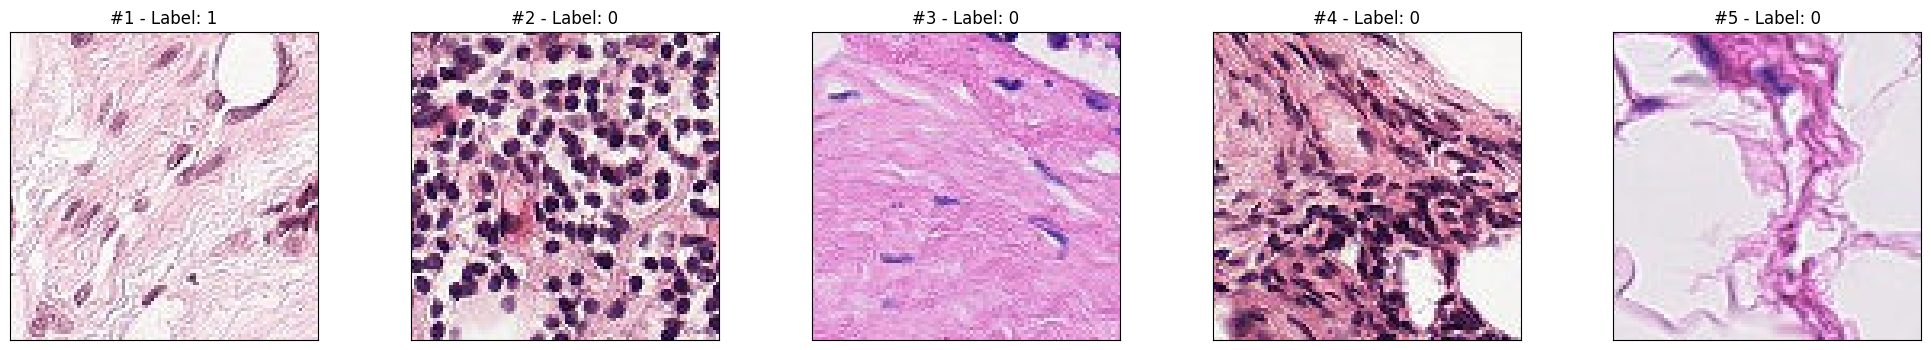

In [8]:
fig = plt.figure(figsize=(25, 4))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    im = Image.open(train + img_train[i])
    plt.imshow(im)
    label = df_labels.loc[df_labels['id'] == img_train[i].split('.')[0], 'label'].values[0]
    ax.set_title(f'#{i+1} - Label: {label}')

Check the data for any blank id's or labels.

In [9]:
# All items in the labels table are non-null
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Plot how many contain malignant or normal cells

([<matplotlib.axis.XTick at 0x7b76cc6b98d0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

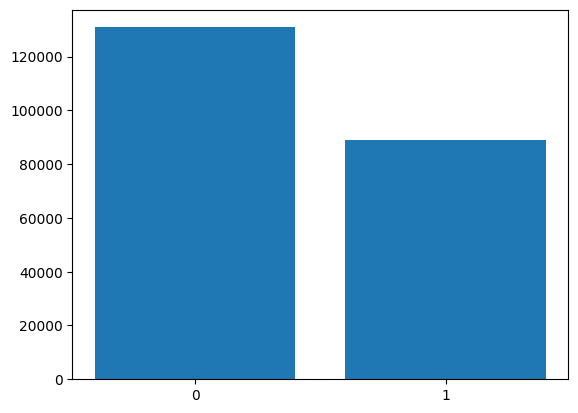

In [54]:
malignant = df_labels.loc[df_labels['label']==1]['id'].values
normal = df_labels.loc[df_labels['label']==0]['id'].values
value_counts = df_labels['label'].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xticks([0, 1])


In [11]:
def plot_fig(ids,title,nrows=3,ncols=3):

    fig,ax = plt.subplots(nrows,ncols,figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(train ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

View samples of Malignant cells.

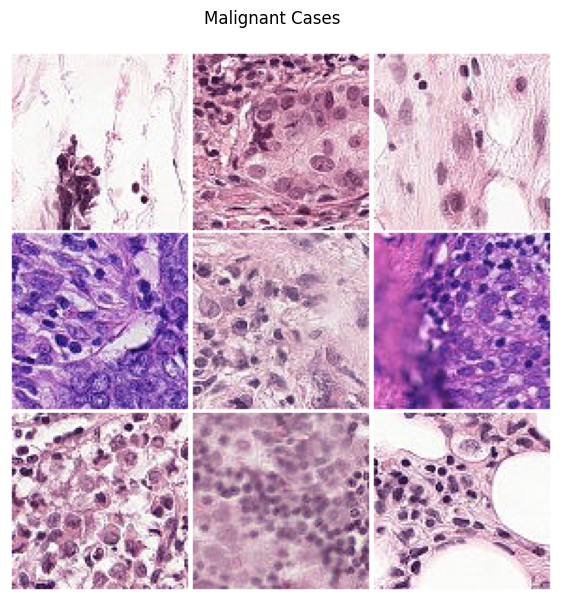

In [12]:
plot_fig(malignant,'Malignant Cases')

View samples of normal cells

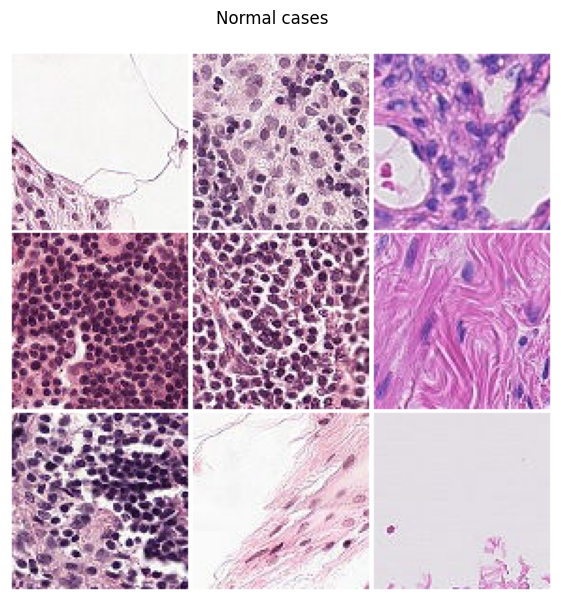

In [13]:
plot_fig(normal,'Normal cases')

Split the training labels into training and validation sets.

In [14]:
train_data, val_data = train_test_split(df_labels, test_size=0.3, random_state=42, stratify=df_labels['label'])

In [15]:
train_data = train_data.astype(str)
val_data = val_data.astype(str)
print(train_data.shape,val_data.shape)

(154017, 2) (66008, 2)


Create an data generator to preprocess the training images.

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [17]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_data['id'] += '.tif'
val_data['id'] += '.tif'

validate images and preprocess them for the training set.

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory = train,
    x_col = 'id',
    y_col = 'label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

Found 154017 validated image filenames belonging to 2 classes.


validate and preprocess images for validation set.

In [20]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = train,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
    class_mode='binary'
)

Found 66008 validated image filenames belonging to 2 classes.


In [21]:
test_data = df_samples.astype(str)
test_data['id'] += '.tif'

In [22]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory = test,
    x_col='id',
    y_col='label',
    target_size=(96,96),
    batch_size=32,
)

Found 57458 validated image filenames belonging to 1 classes.


Define the model with 3 sets of layers that each have two convolutional layers followed by batch normalization (to increase training speed) and maxpool (or downsampling). Each layer increases the number of filters from 16 to 32 to 64.

In [23]:
def CNN(model):
    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(96,96,3)))
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3)))

    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Example of adding L2 regularization
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model

The RMSprop optimizer (Root Mean Square Propigation) which allows the model to have an adaptive learning rate which lessens training time, gradient normalization which normalizes significant changes in gradient across parameters, and exponential moving average which allows for normalizing the impact of gradients.

Using early stopping and validation data to prevent overfitting.

In [24]:
RMS_model = CNN(tf.keras.Sequential())
RMS_model.compile(
    optimizer = 'RMSprop',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

RMS_history = RMS_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=100,
    callbacks=[early_stopping]
)


prediction_labels_1 = RMS_model.predict(test_generator)

Epoch 1/100
4814/4814 [==============================] - 562s 116ms/step - loss: 0.4556 - auc: 0.8848 - val_loss: 0.5383 - val_auc: 0.8848
Epoch 2/100
4814/4814 [==============================] - 566s 118ms/step - loss: 0.3689 - auc: 0.9147 - val_loss: 0.4207 - val_auc: 0.9214
Epoch 3/100
4814/4814 [==============================] - 555s 115ms/step - loss: 0.3448 - auc: 0.9254 - val_loss: 1.3463 - val_auc: 0.7656
Epoch 4/100
4814/4814 [==============================] - 555s 115ms/step - loss: 0.3242 - auc: 0.9342 - val_loss: 0.3593 - val_auc: 0.9328
Epoch 5/100
4814/4814 [==============================] - 543s 113ms/step - loss: 0.3120 - auc: 0.9388 - val_loss: 0.6203 - val_auc: 0.9300
Epoch 6/100
1796/1796 [==============================] - 52s 29ms/step


Predicting the model above, and fitting it into a dataframe to be able to export and validate with confusion matrix.

In [35]:
preds = pd.DataFrame(columns=['id', 'label'])
img_test=sorted(img_test)


preds['id'] = [filename.split('.')[0] for filename in img_test]
preds['label'] = np.round(prediction_labels_1.flatten()).astype('int')
preds

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,1
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,1
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,1
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


Plotting the training loss vs. validation loss.

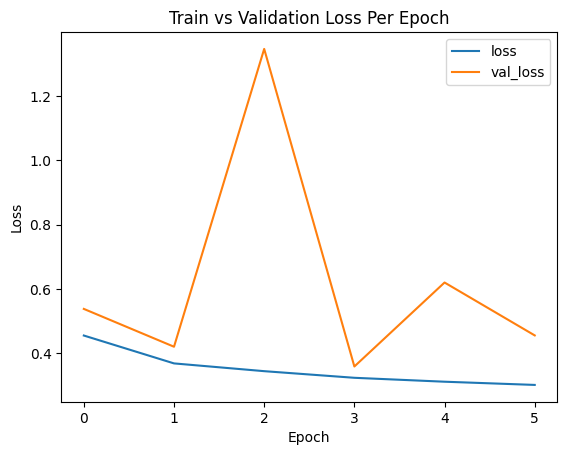

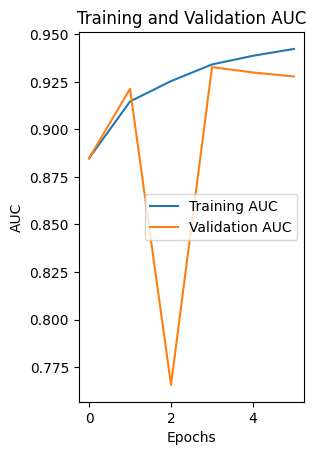

In [26]:
plt.plot(RMS_history.history['loss'], label='loss')
plt.plot(RMS_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

Stochastic Gradient Descent model trained below does not have an adaptive learning rate, but has momentum which helps to excellerate the model in learning. Early stopping also increases the speed as it allows for the max valuable epochs, without going too far in the training to be overfit. Validation data is also used to prevent overfitting.

In [27]:
SGD_model = CNN(tf.keras.Sequential())
SGD_model.compile(
    optimizer = 'SGD',
    loss = 'binary_crossentropy',
    metrics = [AUC()]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

SGD_history= SGD_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=100,
    callbacks=[early_stopping]
)




Epoch 1/100
4814/4814 [==============================] - 537s 111ms/step - loss: 0.7391 - auc_1: 0.8559 - val_loss: 0.7035 - val_auc_1: 0.8528
Epoch 2/100
4814/4814 [==============================] - 539s 112ms/step - loss: 0.4420 - auc_1: 0.8958 - val_loss: 0.3843 - val_auc_1: 0.9167
Epoch 3/100
4814/4814 [==============================] - 536s 111ms/step - loss: 0.3873 - auc_1: 0.9070 - val_loss: 0.4327 - val_auc_1: 0.9144
Epoch 4/100
4814/4814 [==============================] - 538s 112ms/step - loss: 0.3691 - auc_1: 0.9135 - val_loss: 0.4653 - val_auc_1: 0.9197
Epoch 5/100
1796/1796 [==============================] - 53s 29ms/step


In [37]:
preds1_labels = SGD_model.predict(test_generator)

1796/1796 [==============================] - 53s 29ms/step


Compiling the predictions of the SGD optimized model.

In [40]:
preds1 = pd.DataFrame(columns=['id', 'label'])
img_test=sorted(img_test)


preds1['id'] = [filename.split('.')[0] for filename in img_test]
preds1['label'] = np.round(preds1_labels.flatten()).astype('int')
preds1

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,1
4,000270442cc15af719583a8172c87cd2bd9c7746,1
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,1
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,1
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,1
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


Plot the validation AUC vs Training AUC.

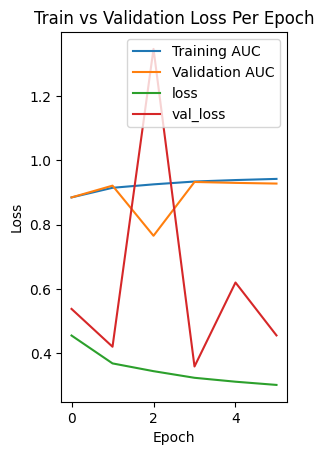

In [29]:
plt.subplot(1, 2, 2)
plt.plot(RMS_history.history['auc'], label='Training AUC')
plt.plot(RMS_history.history['val_auc'], label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

Confusion matrix plotting the test vs labels for both models. All test labels were non-malignant or 0, but the RMS predicted ~13k malignant and SGD ~17k.

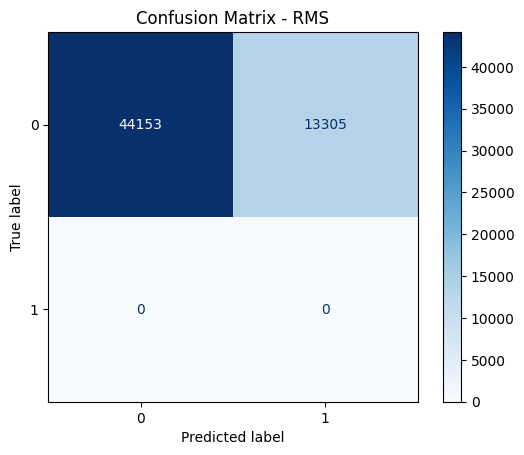

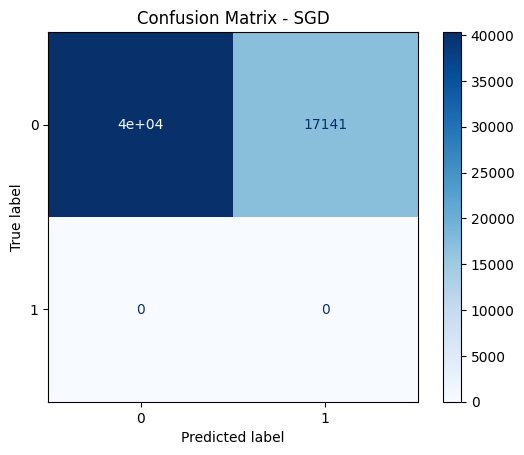

In [55]:
df_samples['label'] = df_samples['label'].astype(int)
preds['label'] = preds['label'].astype(int)
preds1['label'] = preds1['label'].astype(int)
conf_matrix = confusion_matrix(df_samples['label'], preds['label'])
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - RMS')
plt.show()

conf_matrix = confusion_matrix(df_samples['label'], preds1['label'])
ConfusionMatrixDisplay(conf_matrix).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SGD')
plt.show()

In [41]:
preds.to_csv('RMS_final.csv', index=False)
preds1.to_csv('SGD_final.csv', index=False)

In [42]:
from google.colab import files
files.download("RMS_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("SGD_final.csv")

In all this project was a steep learning curve. Being my first time really using Keras, and using images in Python. It was a good experience, but difficult learning the nuances of Keras.

Both models were successful at learning, with the RMS model being more successful at predictions. I am curious and would want to look into the data more on why the test data only had non-cancerous cells. A further iteration could be separating the training data, and allowing the test set to have both malignant and normal cells.

The model which performed better (RMS) scored a .50 in the Kaggle competition. The steps that I would take to further improve include: continue hyperparameter tuning, adding the training set to the test set then splitting off test and validation off of that. There is already more positive than negative, so this would more evenly split the two.